This file is all cleaning and distributions about Diagnoses and prescriptions (Medications).
It contains phecodes cleaning, adding missing phecodes, diagnoses cleaning, demographics cleaning, prescriptions cleaning, merging diagnoses(phecodes) and atccodes and some exploratory data analysis.
The results of these processes stored in dataframe df and df_exp and CSV files: diagnoses_atc_episode.csv and diagnoses_atc_episode_exp.csv
atc in this file finally cut into 4 char just as a try. 

In [1]:
# Imports
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd 
import pickle as pkl
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
# Prescriptions
#Sql query for extracting prescriptions had 56,167 rows
prescriptions_df = pd.read_csv( "/home/kabank/workbench/.conda/analysis/kabank-data/prescriptionsEachSak.csv")
prescriptions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56167 entries, 0 to 56166
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   episode_id         44685 non-null  float64
 1   regulation         56167 non-null  object 
 2   prescription_type  39713 non-null  object 
 3   trade_name         56167 non-null  object 
 4   atc_code           40662 non-null  object 
 5   atc_name           31245 non-null  object 
dtypes: float64(1), object(5)
memory usage: 2.6+ MB


In [3]:
#Phecode that is downloaded directly from (https://phewascatalog.org/phecodes)
phecodes_df = pd.read_csv("/home/kabank/workbench/.conda/analysis/kabank-data/phecode_icd10.csv", decimal=',')
phecodes_df.info() #9505 rows 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9505 entries, 0 to 9504
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ICD10             9505 non-null   object
 1   ICD10 String      9504 non-null   object
 2   PheCode           9366 non-null   object
 3   Phenotype         9366 non-null   object
 4   Excl. Phecodes    8667 non-null   object
 5   Excl. Phenotypes  8608 non-null   object
dtypes: object(6)
memory usage: 445.7+ KB


In [4]:
#47,750 rows: Total rows
# After deleting null values that we have in episdoe_id : 47,742 rows
diagnoses_df = pd.read_csv( "/home/kabank/workbench/.conda/analysis/Resources/Diagnosis.CSV", decimal=',') 
diagnoses_df = diagnoses_df.dropna()
diagnoses_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47742 entries, 0 to 47749
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   patient      47742 non-null  int64  
 1   episode_id   47742 non-null  float64
 2   gender       47742 non-null  object 
 3   axis         47742 non-null  int64  
 4   diagnosis    47742 non-null  object 
 5   age_patient  47742 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 2.5+ MB


# Data Cleaning
# ----------------------------------------- 
# Phecode cleaning
# -----------------------------------------

In [5]:
# Remove punctuation from icd-codes to match data format in diagnoses_df
for i in range(len(phecodes_df["ICD10"])):
    phecodes_df.at[i, "ICD10"] = phecodes_df["ICD10"][i].replace(".", "")

In [6]:
phecodes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9505 entries, 0 to 9504
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ICD10             9505 non-null   object
 1   ICD10 String      9504 non-null   object
 2   PheCode           9366 non-null   object
 3   Phenotype         9366 non-null   object
 4   Excl. Phecodes    8667 non-null   object
 5   Excl. Phenotypes  8608 non-null   object
dtypes: object(6)
memory usage: 445.7+ KB


In [7]:
# 139 rows are null in column PheCode - we remove them  (9505-139 = 9366)
phecodes_df = phecodes_df.dropna(subset=['PheCode'])

In [8]:
phecodes_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9366 entries, 0 to 9503
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ICD10             9366 non-null   object
 1   ICD10 String      9365 non-null   object
 2   PheCode           9366 non-null   object
 3   Phenotype         9366 non-null   object
 4   Excl. Phecodes    8667 non-null   object
 5   Excl. Phenotypes  8608 non-null   object
dtypes: object(6)
memory usage: 512.2+ KB


In [9]:
len(phecodes_df['ICD10'].unique()) # 9060 as it is less than the total number of rows in phecodes_df, there are some duplicates
# Convert phecodes df to dictionary - which automatically removes the duplicates
phecodes_dict = dict([(i, [x, y, z]) for i, x, y, z in zip(phecodes_df['ICD10'],phecodes_df['PheCode'], phecodes_df['Phenotype'], phecodes_df['Excl. Phenotypes'])])

In [10]:
phecodes_df[phecodes_df['ICD10']=='F410']

,ICD10,ICD10 String,PheCode,Phenotype,Excl. Phecodes,Excl. Phenotypes
2503,F410,Panic disorder [episodic paroxysmal anxiety],300.12,"Agorophobia, social phobia, and panic disorder",295-306.99,psychological disorders


In [11]:
phecodes_dict['F410']

['300.12',
 'Agorophobia, social phobia, and panic disorder',
 'psychological disorders']

In [12]:
num_rows_df = len(phecodes_df)
num_keys_dict = len(phecodes_dict)
print(f'There are some duplicate keys in the phecodes_df which have been collapsed in the dictionary (phecodes_dict): {num_rows_df - num_keys_dict} keys')

There are some duplicate keys in the phecodes_df which have been collapsed in the dictionary (phecodes_dict): 306 keys


In [13]:
# check the values in diagnoses_df
list_len_more4 = []
list_len_less4 = []
list_len_equal4 = []
diagnoses_df['diagnosis'] = [X[0:4] for X in diagnoses_df['diagnosis']]
for i in range(len(diagnoses_df)):
    diagnosis = diagnoses_df['diagnosis'].iloc[i]
    if len(diagnosis) > 4:
        list_len_more4.append(diagnosis)       
    if len(diagnosis) < 4:
        list_len_less4.append(diagnosis)
    if len(diagnosis) == 4:
        list_len_equal4.append(diagnosis)

unique_values_less4 = set(list_len_less4)
unique_values_equal4 = set(list_len_equal4)
unique_values_more4 = set(list_len_more4)
unique_total = len(diagnoses_df['diagnosis'].unique())


print(f'count total unique: {unique_total}') #1371
print(f'count less than 4: {len(unique_values_less4)}') #139
print(f'count more than 4: {len(unique_values_more4)}') #0
print(f'count equal than 4: {len(unique_values_equal4)}') #1241
print('***')
print(unique_values_less4)


count total unique: 1371
count less than 4: 130
count more than 4: 0
count equal than 4: 1241
***
{'H52', 'E86', 'R13', 'G09', 'G71', 'Q53', 'F39', 'L40', 'R48', 'N62', 'E66', 'R11', 'G36', 'G80', 'F99', 'P75', 'J45', 'A09', 'F28', 'R31', 'J47', 'F82', 'F29', 'E43', 'O04', 'F88', 'X61', 'C64', 'F55', 'G40', 'H46', 'O94', 'F70', 'D66', 'R52', 'F71', 'F79', 'R29', 'R32', 'R35', 'E73', 'R53', 'R05', 'L50', 'L65', 'D70', 'J46', 'R47', 'R42', 'P77', 'R59', 'W76', 'I64', 'R63', 'M08', 'K59', 'M41', 'B27', 'R96', 'E46', 'L80', 'H54', 'F83', 'F81', 'Q25', 'X6n', 'D50', 'Q96', 'J30', 'K20', 'M54', 'R15', 'G44', 'O85', 'H40', 'T58', 'F89', 'R80', 'F03', 'R55', 'G43', 'N10', 'I60', 'R26', 'E90', 'K21', 'Q64', 'N13', 'F21', 'D27', 'T4n', 'O60', 'C56', 'J03', 'C49', 'H91', 'R72', 'Y4n', 'R01', 'A37', 'X60', 'R51', 'K30', 'H55', 'T71', 'L70', 'X78', 'P90', 'X4n', 'H50', 'F98', 'F80', 'E45', 'N47', 'N30', 'R10', 'N44', 'G91', 'R62', 'E10', 'R12', 'F09', 'F24', 'J36', 'G98', 'F72', 'F69', 'F54', 'L20'

In [14]:
# diagnoses in diagnoses_df that do not have Phecode to be assigned
NotinPhecode = []

for X in diagnoses_df['diagnosis']:
    if X not in phecodes_dict:
        NotinPhecode.append(X)

NotinPhecode2 = set(NotinPhecode) # function to convert a list to a set, which automatically removes duplicates.
print(len(NotinPhecode2))
# 115 unique diagnoses do not have Phecodes

115


In [15]:
print(NotinPhecode2)

{'M814', 'M248', 'M828', 'F530', 'P071', 'T941', 'S361', 'K858', 'X6n9', 'M530', 'R48', 'F791', 'F320', 'N038', 'F180', 'F813', 'X6n1', 'X6n4', 'X6n8', 'Y609', 'F28', 'F718', 'T012', 'M726', 'F403', 'K720', 'F555', 'O04', 'X61', 'Y906', 'F329', 'T742', 'X6n2', 'O94', 'R52', 'R960', 'R29', 'Q914', 'P070', 'F558', 'T748', 'L65', 'F933', 'R47', 'F504', 'X591', 'F518', 'F069', 'T910', 'S327', 'F638', 'M811', 'R456', 'W76', 'R63', 'F710', 'X6n5', 'R636', 'F339', 'F552', 'F900', 'R96', 'K523', 'K649', 'M091', 'F83', 'F81', 'X6n', 'Y912', 'W5nx', 'F982', 'R448', 'X8n2', 'M511', 'X6n6', 'F322', 'X6nx', 'E148', 'J950', 'Y907', 'P043', 'F629', 'E90', 'B209', 'Q315', 'N188', 'G40.', 'Q64', 'F068', 'X6n0', 'T740', 'T142', 'T4n', 'Y913', 'H91', 'F798', 'Y4n', 'X60', 'F908', 'M818', 'F928', 'X4n', 'H50', 'F98', 'M090', 'F623', 'R10', 'F321', 'R62', 'H549', 'T141', 'F323', 'F780', 'Q044', 'P044'}


In [16]:
#those that do not have Phecodes and have a length less than 4
for X in NotinPhecode2:
    if X in unique_values_less4:
        print(X) # 26

R48
F28
O04
X61
O94
R52
R29
L65
R47
W76
R63
R96
F83
F81
X6n
E90
Q64
T4n
H91
Y4n
X60
X4n
H50
F98
R10
R62


In [17]:
j = 0
for i in NotinPhecode2:
    if i not in phecodes_dict.keys():
        print(i) # 115
        j += 1
print(j)     

M814
M248
M828
F530
P071
T941
S361
K858
X6n9
M530
R48
F791
F320
N038
F180
F813
X6n1
X6n4
X6n8
Y609
F28
F718
T012
M726
F403
K720
F555
O04
X61
Y906
F329
T742
X6n2
O94
R52
R960
R29
Q914
P070
F558
T748
L65
F933
R47
F504
X591
F518
F069
T910
S327
F638
M811
R456
W76
R63
F710
X6n5
R636
F339
F552
F900
R96
K523
K649
M091
F83
F81
X6n
Y912
W5nx
F982
R448
X8n2
M511
X6n6
F322
X6nx
E148
J950
Y907
P043
F629
E90
B209
Q315
N188
G40.
Q64
F068
X6n0
T740
T142
T4n
Y913
H91
F798
Y4n
X60
F908
M818
F928
X4n
H50
F98
M090
F623
R10
F321
R62
H549
T141
F323
F780
Q044
P044
115


In [18]:
# Add missing codes to dictionary
phecodes_dict["B209"] = [071.1, 'HIV infection , symptomatic', 'Viral infection']
phecodes_dict["E90"] = [277, 'Other disorders of metabolism', 'Other/unspecified disorders of metabolism']
phecodes_dict["F068"] = [291.4, 'Specific nonpsychotic mental disorders due to brain damage', 'dementia and related cognitive disorders/symptoms']
phecodes_dict["F069"] = [291.4, 'Specific nonpsychotic mental disorders due to brain damage', 'dementia and related cognitive disorders/symptoms']
phecodes_dict["F18"] = [290.3, 'Other persistent mental disorders due to conditions classified elsewhere', 'dementia and related cognitive disorders/symptoms']
phecodes_dict["F180"] = [290.3, 'Other persistent mental disorders due to conditions classified elsewhere', 'dementia and related cognitive disorders/symptoms']
phecodes_dict["F28"] = [295.3, 'Psychosis', 'psychological disorders']
phecodes_dict["F32"] = [296.22, 'Depressive disorder', 'psychological disorders']
phecodes_dict["F320"] = [296.22, 'Depressive disorder', 'psychological disorders']
phecodes_dict["F321"] = [296.22, 'Depressive disorder', 'psychological disorders']
phecodes_dict["F322"] = [296.22, 'Depressive disorder', 'psychological disorders']
phecodes_dict["F323"] = [296.22, 'Depressive disorder', 'psychological disorders']
phecodes_dict["F329"] = [296.22, 'Depressive disorder', 'psychological disorders']
phecodes_dict["F339"] = [296.22, 'Depressive disorder', 'psychological disorders']
phecodes_dict["F204"] = [296.22, 'Depressive disorder', 'psychological disorders']
phecodes_dict["F328"] = [296.22, 'Depressive disorder', 'psychological disorders']
phecodes_dict["F330"] = [296.22, 'Depressive disorder', 'psychological disorders']
phecodes_dict["F331"] = [296.22, 'Depressive disorder', 'psychological disorders']
phecodes_dict["F332"] = [296.22, 'Depressive disorder', 'psychological disorders']
phecodes_dict["F333"] = [296.22, 'Depressive disorder', 'psychological disorders']
phecodes_dict["F334"] = [296.22, 'Depressive disorder', 'psychological disorders']
phecodes_dict["F338"] = [296.22, 'Depressive disorder', 'psychological disorders']
phecodes_dict["F403"] = [300.13, 'Phobia', 'psychological disorders']
phecodes_dict["F064"] = [300.1, 'Anxiety disorder', 'psychological disorders']
phecodes_dict["F40"] = [300.1, 'Anxiety disorder', 'psychological disorders']
phecodes_dict["F400"] = [300.1, 'Anxiety disorder', 'psychological disorders']
phecodes_dict["F401"] = [300.1, 'Anxiety disorder', 'psychological disorders']
phecodes_dict["F402"] = [300.1, 'Anxiety disorder', 'psychological disorders']
phecodes_dict["F408"] = [300.1, 'Anxiety disorder', 'psychological disorders']
phecodes_dict["F409"] = [300.1, 'Anxiety disorder', 'psychological disorders']
phecodes_dict["F410"] = [300.1, 'Anxiety disorder', 'psychological disorders']
phecodes_dict["F411"] = [300.1, 'Anxiety disorder', 'psychological disorders']
phecodes_dict["F412"] = [300.1, 'Anxiety disorder', 'psychological disorders']
phecodes_dict["F413"] = [300.1, 'Anxiety disorder', 'psychological disorders']
phecodes_dict["F418"] = [300.1, 'Anxiety disorder', 'psychological disorders']
phecodes_dict["F419"] = [300.1, 'Anxiety disorder', 'psychological disorders']
phecodes_dict["F606"] = [300.1, 'Anxiety disorder', 'psychological disorders']
phecodes_dict["F930"] = [300.1, 'Anxiety disorder', 'psychological disorders']
phecodes_dict["F931"] = [300.1, 'Anxiety disorder', 'psychological disorders']
phecodes_dict["F932"] = [300.1, 'Anxiety disorder', 'psychological disorders']
phecodes_dict["F500"] = [305.2, 'Eating disorder', 'psychological disorders']
phecodes_dict["F504"] = [305.2, 'Eating disorder', 'psychological disorders']
phecodes_dict["F518"] = [327, 'Sleep disorders', 'Sleep disorders']
phecodes_dict["F552"] = [316, 'Substance addiction and disorders', 'Substance -related disorders'] 
phecodes_dict["F555"] = [316, 'Substance addiction and disorders', 'Substance -related disorders']
phecodes_dict["F558"] = [316, 'Substance addiction and disorders', 'Substance -related disorders']
phecodes_dict["F623"] = [306, 'Other mental disorder', 'psychological disorders']
phecodes_dict["F638"] = [312.3, 'Impulse control disorder', 'Developmental/behavioral disorders']
phecodes_dict["F629"] = [306, 'Other mental disorder', 'psychological disorders']
phecodes_dict["F7"] = [315.3, 'Mental retardation', 'Developmental/behavioral disorders']
phecodes_dict["F710"] = [315.3, 'Mental retardation', 'Developmental/behavioral disorders']
phecodes_dict["F718"] = [315.3, 'Mental retardation', 'Developmental/behavioral disorders']
phecodes_dict["F780"] = [315.3, 'Mental retardation', 'Developmental/behavioral disorders']
phecodes_dict["F791"] = [315.3, 'Mental retardation', 'Developmental/behavioral disorders']
phecodes_dict["F798"] = [315.3, 'Mental retardation', 'Developmental/behavioral disorders']
phecodes_dict["F81"] = [315.1, 'Learning disorder', 'Developmental/behavioral disorders'] 
phecodes_dict["F813"] = [315.1, 'Learning disorder', 'Developmental/behavioral disorders'] 
phecodes_dict["F83"] = [315.1, 'Learning disorder', 'Developmental/behavioral disorders']
phecodes_dict["F900"] = [313.1, 'Attention deficit hyperactivity disorder', 'Developmental/behavioral disorders'] 
phecodes_dict["F908"] = [313.1, 'Attention deficit hyperactivity disorder', 'Developmental/behavioral disorders']
phecodes_dict["F928"] = [312, 'Conduct disorders', 'Developmental/behavioral disorders']
phecodes_dict["F933"] = [313, 'Pervasive developmental disorders', 'Developmental/behavioral disorders']
phecodes_dict["F98"] = [313, 'Pervasive developmental disorders', 'Developmental/behavioral disorders'] 
phecodes_dict["F982"] = [305.2, 'Eating disorder', 'psychological disorders']
phecodes_dict["G40."] = [345, 'Epilepsy , recurrent seizures , convulsions', 'hereditary/degenerative nervous conditions ; other diseases of CNS']
phecodes_dict["H50"] = [378.1, 'Strabismus (not specified as paralytic)', 'other eye disorders']
phecodes_dict["H549"] = [367.9, 'Blindness and low vision', 'Blindness and low vision']
phecodes_dict["H91"] = [389, 'Hearing loss', 'Hearing loss and related disorders']
phecodes_dict["J951"] = [519.2, 'Respiratory complications', 'tracheostomy complications']
phecodes_dict["K523"] = [555.2, 'Ulcerative colitis', 'noninfective gastrointestinal disorders']
phecodes_dict["K649"] = [455, 'Hemorrhoids', 'diseases of veins and lymphatics']
phecodes_dict["K720"] = [571.8, 'Liver abscess and sequelae of chronic liver disease', 'Liver disease']
phecodes_dict["K858"] = [577.1, 'Acute pancreatitis', 'pancreatic disorders']
phecodes_dict["L65"] = [704.1, 'Alopecia', 'Diseases of hair and nails ']
phecodes_dict["M090"] = [714.2, 'Juvenile rheumatoid arthritis', 'Autoimmune arthritis and psoriasis'] 
phecodes_dict["M091"] = [714.2, 'Juvenile rheumatoid arthritis', 'Autoimmune arthritis and psoriasis'] 
phecodes_dict["M248"] = [742.9, 'Other derangement of joint', 'other non-traumatic joint disorders'] 
phecodes_dict["M609"] = [313.1, 'Myopathy', 'Disorders of the peripheral nervous system'] 
phecodes_dict["M726"] = [727, 'Symptoms of the muscles', 'Other muscular symptoms']
phecodes_dict["M828"] = [743.1, 'Osteoporosis NOS', 'osteopenia , osteoporosis , pathological fractures']
phecodes_dict["N038"] = [580.14, 'Chronic glomerulonephritis, NOS', 'diseases of kidney and ureters']
phecodes_dict["O04"] = [634, 'Miscarriage; stillbirth', 'complications of pregnancy'] 
phecodes_dict["O94"] = [676, 'Other disorders of the breast associated with childbirth and disorders of lactation', 'COMPLICATIONS OF THE PUERPERIUM']
phecodes_dict["P043"] = [658, 'Maternal complication of pregnancy affecting fetus or newborn', 'Maternal complication of pregnancy affecting fetus or newborn']
phecodes_dict["P044"] = [658, 'Maternal complication of pregnancyaffecting fetus or newborn', 'Maternal complication of pregnancy affecting fetus or newborn']
phecodes_dict["P070"] = [637, 'Short gestation; low birth weight; and fetal growth retardation', 'miscarriage, early labor, hemorrhage']
phecodes_dict["P071"] = [637, 'Short gestation; low birth weight; and fetal growth retardation ', 'miscarriage, early labor, hemorrhage']
phecodes_dict["Q044"] = [752.2, 'Other specified congenital anomalies of nervous system', 'congenital anomalies of nervous system, spine']
phecodes_dict["Q315"] = [748, 'Anomalies of respiratory system, congenital', 'congenital anomalies of respiratory system, face and neck']
phecodes_dict["Q64"] = [751.2, 'Congenital anomalies of urinary system', 'congenital anomalies of gi, urinary tract']
phecodes_dict["Q900"] = [758.1, 'Chromosomal anomalies', 'All other congenital anomalies']
phecodes_dict["Q914"] = [758.1, 'Chromosomal anomalies', 'All other congenital anomalies']
phecodes_dict["S327"] = [1009, 'Injury, NOS', None]
phecodes_dict["S361"] = [1008, 'Crushing or internal injury to organs', None]
phecodes_dict["T012"] = [870, 'Open wounds of head; neck; and trunk', 'Open wound'] 
phecodes_dict["T141"] = [1009, 'Injury, NOS', None]
phecodes_dict["T142"] = [1009, 'Injury, NOS', None] 
phecodes_dict["T4n"] = [969, 'Poisoning by psychotropic agents', 'Poisoning By Drugs , Medicinal And Biological Substances']
phecodes_dict["T740"] = [1015, 'Effects of other external causes', None]
phecodes_dict["T748"] = [1015, 'Effects of other external causes', None]
phecodes_dict["T742"] = [1015, 'Effects of other external causes', None]
phecodes_dict["X4n"] = [981, 'Toxic effect of (non-ethyl) alcohol and petroleum and other solvents', 'Toxic effects of substances chiefly nonmedicinal as to source']
phecodes_dict["X6n"] = [297.2, 'Suicide or self-inflicted injury', 'psychological disorders']
phecodes_dict["X61"] = [297.2, 'Suicide or self-inflicted injury', 'psychological disorders'] 
phecodes_dict["X60"] = [297.2, 'Suicide or self-inflicted injury', 'psychological disorders']
phecodes_dict["X6nx"] = [297.2, 'Suicide or self-inflicted injury', 'psychological disorders']
phecodes_dict["X6n0"] = [297.2, 'Suicide or self-inflicted injury', 'psychological disorders'] 
phecodes_dict["X6n1"] = [297.2, 'Suicide or self-inflicted injury', 'psychological disorders']
phecodes_dict["X6n2"] = [297.2, 'Suicide or self-inflicted injury', 'psychological disorders'] 
phecodes_dict["X6n4"] = [297.2, 'Suicide or self-inflicted injury', 'psychological disorders']
phecodes_dict["X6n5"] = [297.2, 'Suicide or self-inflicted injury', 'psychological disorders'] 
phecodes_dict["X6n6"] = [297.2, 'Suicide or self-inflicted injury', 'psychological disorders']
phecodes_dict["X6n8"] = [297.2, 'Suicide or self-inflicted injury', 'psychological disorders'] 
phecodes_dict["X6n9"] = [297.2, 'Suicide or self-inflicted injury', 'psychological disorders']
phecodes_dict["Y912"] = [981, 'Toxic effect of (non-ethyl) alcohol and petroleum and other solvents', 'Toxic effects of substances chiefly nonmedicinal as to source']
phecodes_dict["Y913"] = [981, 'Toxic effect of (non-ethyl) alcohol and petroleum and other solvents', 'Toxic effects of substances chiefly nonmedicinal as to source']
##
phecodes_dict["Y4n"] =  [979, 'Adverse drug events and drug allergies', None]
phecodes_dict["F530"] = [674, 'Other complications of the puerperium, not elsewhere classified', None]
phecodes_dict["X8n2"] = [297.2, 'Suicide or self-inflicted injury', None]
phecodes_dict["W76"]  = [297.2, 'Suicide or self-inflicted injury', None]
phecodes_dict["J950"] = [519, 'Other diseases of respiratory system, not elsewhere classified', None]
phecodes_dict["W5nx"] = [939, 'Atopic/contact dermatitis due to other or unspecified', None]
phecodes_dict["X591"] = [1015, 'Effects of other external causes', None]
phecodes_dict["Y609"] = [1011, 'Complications of surgical and medical procedures', None]
phecodes_dict["T910"] = [915, 'Superficial injury without mention of infection', None]
phecodes_dict["T941"] = [1009, 'Injury, NOS ', None]
phecodes_dict["Y906"] = [317, 'Alcohol-related disorders', None]
phecodes_dict["Y907"] = [317, 'Alcohol-related disorders', None]
##
phecodes_dict["M811"] = [1020, 'Juvenile osteochondrosis of hip and pelvis', None]
phecodes_dict["R47"] = [1021, 'Voice and resonance disorders', None]
phecodes_dict["R62"] = [1022, 'Lack of expected normal physiological development in childhood', None]
phecodes_dict["R448"] = [1023, None, None]
phecodes_dict["R960"] = [1024, 'Elevated prostate specific antigen [PSA]', None]
phecodes_dict["E148"] = [1025, 'Other specified diabetes mellitus with unspecified complications', None]
phecodes_dict["R96"] = [1026, 'Other sudden death, cause unknown', None]
phecodes_dict["M530"] = [1027, 'Other specified dorsopathies, not elsewhere classified', None]
phecodes_dict["R52"] = [1028, 'Pain, unspecified', None]
phecodes_dict["R456"] = [1029, 'Sudden alteration of consciousness', None]
phecodes_dict["N188"] = [1030, 'Other chronic kidney disease, stage 1', None]
phecodes_dict["R10"] = [1031, 'Abdominal and pelvic pain', None]
phecodes_dict["R48"] = [1032, 'Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified', None]
phecodes_dict["R636"] = [1033, 'Polydipsia', None]
phecodes_dict["R29"] = [1034, 'Other symptoms and signs involving the nervous and musculoskeletal systems', None]
phecodes_dict["R63"] = [1033, 'Polydipsia', None]
phecodes_dict["M818"] = [1035, 'Other osteoporosis with pathological fracture', None]
phecodes_dict["M511"] = [1036, 'Other intervertebral disc displacement, lumbar region', None]
phecodes_dict["M814"] = [1037, 'Age-related osteoporosis with current pathological fracture', None]

In [19]:
len(phecodes_dict)
# before 9060 now 9179, 119 ICD10 are added

9179

In [20]:
# to find values in diagnoses_df['diagnosis'] that are not in phecodes_df['ICD10'] 
# Using isin() and ~ operator 
values_only_in_diagnoses_df = diagnoses_df[~diagnoses_df['diagnosis'].isin(phecodes_dict.keys())]['diagnosis']
print(f"all not exist: {len(values_only_in_diagnoses_df)}")
# The variable 'values_only_in_diagnoses_df' now contains the values in diagnoses_df['diagnosis'] that are not in phecodes_df['ICD10'] 
values_only_in_diagnoses_arr = values_only_in_diagnoses_df.unique()
print(len(values_only_in_diagnoses_arr),'unique ICD10 codes do not have corresponding phecodes:')
print(values_only_in_diagnoses_arr)


all not exist: 0
0 unique ICD10 codes do not have corresponding phecodes:
[]


In [21]:
#serialize and save the dictionary object into a file
pkl.dump(phecodes_dict , open('/home/kabank/workbench/.conda/analysis/kabank-data/phecodes_dict.pkl', 'wb'), protocol=4)

# ----------------------------------------- 
# Diagnoses cleaning
# -----------------------------------------

In [22]:
def replace_icd_with_phenotype(df): 
    col = "diagnosis"
    for i in df.index:
        if len(df[col][i]) > 4:
            # Shorten codes that are too long
            df.at[i, col] = df[col][i][:4]
        if df[col][i] in phecodes_dict:
            # Replace ICD-code with phenotype (actually with the column of Phecode)
            icd_code = df.at[i, col]
            #phecodes_dict['A00'][0] is 008
            df.at[i, col] = phecodes_dict[icd_code][0]
        else:
            df.drop(index=i, inplace=True)

replace_icd_with_phenotype(diagnoses_df)

In [23]:
len(diagnoses_df)

47742

In [24]:
diagnoses_df.head()

,patient,episode_id,gender,axis,diagnosis,age_patient
0,20323,13888.0,F,3,315.3,14
1,5513,19229.0,M,1,313,5
2,7620,10030.0,F,1,313,8
3,11364,21538.0,M,1,313.1,7
4,13712,23240.0,M,1,313.1,10


In [25]:
# Drop rows with null
diagnoses_df = diagnoses_df.dropna(subset=['episode_id']) 
diagnoses_df = diagnoses_df.dropna(subset=['gender'])
diagnoses_df = diagnoses_df.dropna(subset=['diagnosis']) 
diagnoses_df = diagnoses_df.dropna(subset=['age_patient'])

In [26]:
len(diagnoses_df)

47742

In [27]:
# Group the diagnoses and drop diagnoses with less than 3 occurrences
diagnoses_df = diagnoses_df.groupby("diagnosis").filter(lambda x: len(x) > 3)

In [28]:
diagnoses_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47194 entries, 0 to 47749
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   patient      47194 non-null  int64  
 1   episode_id   47194 non-null  float64
 2   gender       47194 non-null  object 
 3   axis         47194 non-null  int64  
 4   diagnosis    47194 non-null  object 
 5   age_patient  47194 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 2.5+ MB


In [29]:
diagnoses_df.groupby('axis')['episode_id'].nunique()

axis
1    15610
2     2157
3      307
4     4893
Name: episode_id, dtype: int64

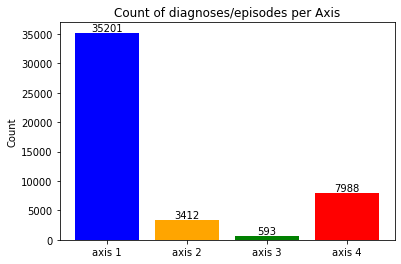

In [30]:
# Count of diagnoses/episodes per Axis

counts = diagnoses_df.groupby('axis')['diagnosis'].count()
# Create a bar chart
bars = plt.bar(counts.index, counts.values, color = ['blue', 'orange', 'green', 'red'])
custom_labels = ['axis 1', 'axis 2', 'axis 3', 'axis 4']  # Replace with your labels
plt.xticks(counts.index, custom_labels)
# Add labels and title
plt.ylabel('Count')
plt.title('Count of diagnoses/episodes per Axis')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom', fontsize=10)

# Show the plot
plt.show()


In [31]:
print(diagnoses_df)

       patient  episode_id gender  axis diagnosis  age_patient
0        20323     13888.0      F     3     315.3           14
1         5513     19229.0      M     1       313            5
2         7620     10030.0      F     1       313            8
3        11364     21538.0      M     1     313.1            7
4        13712     23240.0      M     1     313.1           10
...        ...         ...    ...   ...       ...          ...
47745     9565     26054.0      M     1       304            5
47746    22623     12970.0      F     1       292           16
47747    16115     19994.0      M     1     313.3           11
47748    11080     21557.0      M     1    296.22           16
47749      751     17944.0      F     1     300.3           12

[47194 rows x 6 columns]


In [32]:
# df containing list of diagnoses
diagnoses_list_df = diagnoses_df.drop(["patient", "axis"], axis=1)
diagnoses_list_df['diagnosis'] = diagnoses_list_df['diagnosis']. astype(str)
diagnoses_list_df.head()

,episode_id,gender,diagnosis,age_patient
0,13888.0,F,315.3,14
1,19229.0,M,313,5
2,10030.0,F,313,8
3,21538.0,M,313.1,7
4,23240.0,M,313.1,10


In [33]:
diagnoses_list_df = diagnoses_list_df.groupby('episode_id').agg({
    'diagnosis': lambda x: list(set(x)), 
    'gender': 'min', 
    'age_patient': 'min'
})
diagnoses_list_df["age_patient"] = diagnoses_list_df["age_patient"].astype(int)

diagnoses_list_df.info()
diagnoses_list_df.head()


<class 'pandas.core.frame.DataFrame'>
Index: 17798 entries, 4.0 to 30938.0
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   diagnosis    17798 non-null  object
 1   gender       17798 non-null  object
 2   age_patient  17798 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 556.2+ KB


,diagnosis,gender,age_patient
episode_id,,,
4.0,"[313.1, 1019, 327]",F,14
6.0,[300.1],M,13
7.0,[278.1],M,14
8.0,[296.22],F,17
9.0,"[304, 295, 296.22]",F,17


# ----------------------------------------- 
# Demographics cleaning
# -----------------------------------------

# Add age group column
diagnoses_list_df.loc[diagnoses_list_df["age_patient"].between(0, 5), ["age_group"]] = "Preschooler"
diagnoses_list_df.loc[diagnoses_list_df["age_patient"].between(6, 11), ["age_group"]] = "MiddleChildhood"
diagnoses_list_df.loc[diagnoses_list_df["age_patient"].between(12, 18), ["age_group"]] = "Teenager" 
diagnoses_list_df.loc[diagnoses_list_df["age_patient"].between(19, 60), ["age_group"]] = "Adult"

diagnoses_list_df[diagnoses_list_df["age_group"].isna()]

In [34]:
diagnoses_list_df = diagnoses_list_df[["diagnosis"]]
diagnoses_list_df = diagnoses_list_df.rename(columns={"diagnosis": "diagnoses"})

In [35]:
diagnoses_list_df.head()

,diagnoses
episode_id,
4.0,"[313.1, 1019, 327]"
6.0,[300.1]
7.0,[278.1]
8.0,[296.22]
9.0,"[304, 295, 296.22]"


In [36]:
len(diagnoses_list_df) # 17,798

17798

# Drop 38 records with no gender info, 
diagnoses_list_df = diagnoses_list_df.drop( diagnoses_list_df[diagnoses_list_df['gender'] == "0"].index)
len(diagnoses_list_df) #17,760

In [37]:
diagnoses_list_df.head()

,diagnoses
episode_id,
4.0,"[313.1, 1019, 327]"
6.0,[300.1]
7.0,[278.1]
8.0,[296.22]
9.0,"[304, 295, 296.22]"


#167 have age_group = "Adult"
# Drop adults, because not that many and CAMHS are mainly for children and adolescents
diagnoses_list_df = diagnoses_list_df.drop(diagnoses_list_df[diagnoses_list_df['age_group'] == "Adult"]. index)
len(diagnoses_list_df) #17593

In [38]:
diagnoses_list_df.head()

,diagnoses
episode_id,
4.0,"[313.1, 1019, 327]"
6.0,[300.1]
7.0,[278.1]
8.0,[296.22]
9.0,"[304, 295, 296.22]"


# 2 have age_group=NaN
diagnoses_list_df = diagnoses_list_df.dropna(subset=['age_group'])
len(diagnoses_list_df) #17591

In [39]:
# Remove dots in diagnoses
for index, row in diagnoses_list_df.iterrows():
    for j in range(len(row['diagnoses'])):
        row['diagnoses'][j] = str(row['diagnoses'][j]).replace( '.', '')

In [40]:
diagnoses_list_df.to_csv("/home/kabank/workbench/.conda/analysis/kabank-data/diagnoses_listed.csv")

In [41]:
diagnoses_list_df.shape

(17798, 1)

In [42]:
diagnoses_list_df.head()

,diagnoses
episode_id,
4.0,"[3131, 1019, 327]"
6.0,[3001]
7.0,[2781]
8.0,[29622]
9.0,"[304, 295, 29622]"


# ----------------------------------------- 
# Prescriptions cleaning
# -----------------------------------------

In [43]:
prescriptions_df.head()

,episode_id,regulation,prescription_type,trade_name,atc_code,atc_name
0,9.0,Fast,Blå,Zoloft,N06AB06,Sertralin
1,9.0,Fast,Blå,Zoloft,N06AB06,Sertralin
2,9.0,Fast,Blå,Zoloft,N06AB06,Sertralin
3,9.0,Fast,Blå,Fontex,N06AB03,Fluoksetin
4,27.0,Fast,Hvit,CIRCADIN,N05CH01,Melatonin


In [44]:
prescriptions_df.info()
# 11482 rows do not have episode_id

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56167 entries, 0 to 56166
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   episode_id         44685 non-null  float64
 1   regulation         56167 non-null  object 
 2   prescription_type  39713 non-null  object 
 3   trade_name         56167 non-null  object 
 4   atc_code           40662 non-null  object 
 5   atc_name           31245 non-null  object 
dtypes: float64(1), object(5)
memory usage: 2.6+ MB


In [45]:
# Remove spacing in atc codes
prescriptions_df["atc_code"] = [str(x).replace(' ', '') for x in prescriptions_df["atc_code"]]

In [46]:
# Remove the prescription records with  no episodes id 
len(prescriptions_df[prescriptions_df['episode_id'].isna()]) #11,482
prescriptions_df = prescriptions_df.drop(prescriptions_df[prescriptions_df['episode_id'].isna()].index)
prescriptions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44685 entries, 0 to 44684
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   episode_id         44685 non-null  float64
 1   regulation         44685 non-null  object 
 2   prescription_type  39697 non-null  object 
 3   trade_name         44685 non-null  object 
 4   atc_code           44685 non-null  object 
 5   atc_name           31242 non-null  object 
dtypes: float64(1), object(5)
memory usage: 2.0+ MB


In [47]:
len(prescriptions_df[(prescriptions_df['atc_code'] == 'nan')]) #4,026

4026

In [48]:
len(prescriptions_df[(prescriptions_df['atc_code'].isna())]) #0

0

In [49]:
# The update to the ATC codes was carried out by using the trade names of the drugs
def update_atc_code(df):
    #df.atc_code = np.where(((df.atc_code == 'nan') & (df.trade_name.str.contains('Antiepileptika'))), 'N03A', df. atc_code)
    #df.atc_code = np.where(((df.atc_code == 'nan') & ( df.trade_name.str.contains('Antidepresiva'))), 'N06A', df.atc_code)
    df.atc_code = np.where((((df.atc_code.isna()) | (df.atc_code == 'nan')) & (df.trade_name == 'Concerta')), 'N06BA04', df.atc_code) 
    df.atc_code = np.where((((df.atc_code.isna()) | (df.atc_code == 'nan')) & (df.trade_name == 'Dexidrine')), 'N06BA02', df.atc_code) 
    df.atc_code = np.where((((df.atc_code.isna()) | (df.atc_code == 'nan')) & (df.trade_name == 'Melatonin')), 'N05CH01', df.atc_code) 
    df.atc_code = np.where((((df.atc_code.isna()) | (df.atc_code == 'nan')) & (df.trade_name == 'Metamina')), 'N06BA02', df.atc_code) 
    #df.atc_code = np.where(((df.atc_code == 'nan') & (df.trade_name.str.contains('Nevroleptika'))), 'N05A', df. atc_code)
    #df.atc_code = np.where(((df.atc_code == 'nan') & ( df.trade_name.str.contains('Sentralstimulerende'))), 'N06BA', df.atc_code)

update_atc_code(prescriptions_df)

In [50]:
# The rest that we did not replace with any atc code
print('Number of rows that atc_code is nan:', len(prescriptions_df[((prescriptions_df['atc_code'].isna())| (prescriptions_df['atc_code'] == 'nan'))]))
unique_trade_name_of_nans = prescriptions_df[((prescriptions_df['atc_code'].isna())| (prescriptions_df['atc_code'] == 'nan'))]['trade_name'].unique()
print(unique_trade_name_of_nans,len(unique_trade_name_of_nans))

Number of rows that atc_code is nan: 19
['Frebini energy Drink Banan' 'Frebini energy fibre Drink sjokolade'
 'Nutridrink Multi Fibre jordbær' 'Frebini energy fibre Drink vanilje'
 'Nutridrink Compact jordbær'] 5


In [51]:
# Remove the prescriptions that we did not have the related atc-codes which were all some energy drinks
len(prescriptions_df[((prescriptions_df['atc_code'].isna())| (prescriptions_df['atc_code'] == 'nan'))]) #19
prescriptions_df = prescriptions_df.drop(prescriptions_df[((prescriptions_df['atc_code'].isna())| (prescriptions_df['atc_code'] == 'nan'))].index)
prescriptions_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44666 entries, 0 to 44684
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   episode_id         44666 non-null  float64
 1   regulation         44666 non-null  object 
 2   prescription_type  39680 non-null  object 
 3   trade_name         44666 non-null  object 
 4   atc_code           44666 non-null  object 
 5   atc_name           31242 non-null  object 
dtypes: float64(1), object(5)
memory usage: 2.4+ MB


In [52]:
prescriptions_df[prescriptions_df['episode_id']==9]

,episode_id,regulation,prescription_type,trade_name,atc_code,atc_name
0,9.0,Fast,Blå,Zoloft,N06AB06,Sertralin
1,9.0,Fast,Blå,Zoloft,N06AB06,Sertralin
2,9.0,Fast,Blå,Zoloft,N06AB06,Sertralin
3,9.0,Fast,Blå,Fontex,N06AB03,Fluoksetin


In [53]:
# making new dataframe: atc_df
atc_df = prescriptions_df[["episode_id", "atc_code"]].copy()
atc_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44666 entries, 0 to 44684
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   episode_id  44666 non-null  float64
 1   atc_code    44666 non-null  object 
dtypes: float64(1), object(1)
memory usage: 1.0+ MB


In [54]:
atc_df[["episode_id", "atc_code"]].drop_duplicates()

,episode_id,atc_code
0,9.0,N06AB06
3,9.0,N06AB03
4,27.0,N05CH01
5,27.0,N06BA04
6,27.0,R06AD01
...,...,...
44674,30914.0,N06BA12
44676,30914.0,A06BA04
44677,30914.0,N06BA04
44678,30936.0,N06AB06


In [55]:
atc_df[["atc_code"]].drop_duplicates()
#atc_df[["episode_id"]].drop_duplicates()

,atc_code
0,N06AB06
3,N06AB03
4,N05CH01
5,N06BA04
6,R06AD01
...,...
38905,N05AD01
39057,B03BA03
41421,B03BA01
42305,N01BB02


In [56]:
# Cut atc codes at 4 letters
atc_df["atc_code_4"] = [x[0:4] for x in atc_df["atc_code"]]

In [57]:
# Cut atc codes at 5 letters
atc_df["atc_code_5"] = [x[0:5] for x in atc_df["atc_code"]]

In [58]:
# Cut atc codes at 3 letters
atc_df["atc_code_3"] = [x[0:3] for x in atc_df["atc_code"]]

In [59]:
# Cut atc codes at 1 letters
atc_df["atc_code_1"] = [x[0:1] for x in atc_df["atc_code"]]

In [60]:
# Cut atc codes at 4 letters
atc_df["atc_code"] = [x[0:4] for x in atc_df["atc_code"]]
# Replace "O" with 0, because one instance is NO6B and not N06B
atc_df["atc_code"] = [str(x).replace('O', '0') for x in atc_df["atc_code"]]


In [61]:
atc_df.head()

,episode_id,atc_code,atc_code_4,atc_code_5,atc_code_3,atc_code_1
0,9.0,N06A,N06A,N06AB,N06,N
1,9.0,N06A,N06A,N06AB,N06,N
2,9.0,N06A,N06A,N06AB,N06,N
3,9.0,N06A,N06A,N06AB,N06,N
4,27.0,N05C,N05C,N05CH,N05,N


In [62]:
# Make a dictionary to be used for converting letters in atc codes to numbers.
# The dictionary is needed because FPMax and Apriori only accepts numbers
alphabet_dict = {}
for i in range(26):
    letter = chr(i + ord('A'))
    if i < 9:
        alphabet_dict[letter] = "0" + str(i + 1)
    else:
        alphabet_dict[letter] = str(i + 1)
        
pkl.dump(alphabet_dict , open('/home/kabank/workbench/.conda/analysis/kabank-data/alphabet_dict.pkl', 'wb'), protocol=4)

In [63]:
print(alphabet_dict)

{'A': '01', 'B': '02', 'C': '03', 'D': '04', 'E': '05', 'F': '06', 'G': '07', 'H': '08', 'I': '09', 'J': '10', 'K': '11', 'L': '12', 'M': '13', 'N': '14', 'O': '15', 'P': '16', 'Q': '17', 'R': '18', 'S': '19', 'T': '20', 'U': '21', 'V': '22', 'W': '23', 'X': '24', 'Y': '25', 'Z': '26'}


In [64]:
print(atc_df)

       episode_id atc_code atc_code_4 atc_code_5 atc_code_3 atc_code_1
0             9.0     N06A       N06A      N06AB        N06          N
1             9.0     N06A       N06A      N06AB        N06          N
2             9.0     N06A       N06A      N06AB        N06          N
3             9.0     N06A       N06A      N06AB        N06          N
4            27.0     N05C       N05C      N05CH        N05          N
...           ...      ...        ...        ...        ...        ...
44680     30938.0     N06B       N06B      N06BA        N06          N
44681     30938.0     N06B       N06B      N06BA        N06          N
44682     30938.0     N06B       N06B      N06BA        N06          N
44683     30938.0     N06B       N06B      N06BA        N06          N
44684     30938.0     N06B       N06B      N06BA        N06          N

[44666 rows x 6 columns]


In [65]:
print(atc_df['atc_code'])

0        N06A
1        N06A
2        N06A
3        N06A
4        N05C
         ... 
44680    N06B
44681    N06B
44682    N06B
44683    N06B
44684    N06B
Name: atc_code, Length: 44666, dtype: object


In [66]:
# Convert atc codes to numbers. Adding "999" in the beginning of all codes to be able to separate the codes from diagnosid codes
for i in atc_df.index:
    atc = atc_df["atc_code"][i]
    atc_string = "999" + alphabet_dict[atc[0]] + atc[1:3] + alphabet_dict[atc[3]]
    atc_df.loc[i, "atc_code"] = atc_string

atc_list_df = atc_df.copy()
atc_list_df = atc_list_df.groupby('episode_id').agg( {'atc_code': lambda x: list(set(x))})
atc_list_df.to_csv("/home/kabank/workbench/.conda/analysis/kabank-data/atc_listed.csv")

In [67]:
atc_list_df.head()

,atc_code
episode_id,
9.0,[999140601]
27.0,"[999140503, 999180601, 999140601, 999140602]"
28.0,[999140601]
34.0,"[999140503, 999080102, 999040601, 999140602]"
38.0,"[999140502, 999140601]"


In [68]:
atc_list_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4459 entries, 9.0 to 30938.0
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   atc_code  4459 non-null   object
dtypes: object(1)
memory usage: 69.7+ KB


In [69]:
diagnoses_list_df.head()

,diagnoses
episode_id,
4.0,"[3131, 1019, 327]"
6.0,[3001]
7.0,[2781]
8.0,[29622]
9.0,"[304, 295, 29622]"


In [70]:
atc_list = pd.read_csv("/home/kabank/workbench/.conda/analysis/kabank-data/atc_listed.csv")
diagnoses_list = pd.read_csv("/home/kabank/workbench/.conda/analysis/kabank-data/diagnoses_listed.csv")
atc_list.rename(columns={'atc_code': 'atc_codes'}, inplace=True)

In [71]:
print('shape of atc dataframe:', atc_list.shape)
print('shape of diagnoses dataframe:', diagnoses_list.shape)

shape of atc dataframe: (4459, 2)
shape of diagnoses dataframe: (17798, 2)


In [72]:
atc_list.head()

,episode_id,atc_codes
0,9.0,['999140601']
1,27.0,"['999140503', '999180601', '999140601', '99914..."
2,28.0,['999140601']
3,34.0,"['999140503', '999080102', '999040601', '99914..."
4,38.0,"['999140502', '999140601']"


In [73]:
diagnoses_list.head()

,episode_id,diagnoses
0,4.0,"['3131', '1019', '327']"
1,6.0,['3001']
2,7.0,['2781']
3,8.0,['29622']
4,9.0,"['304', '295', '29622']"


# Merging diagnoses and ATCs

In [74]:
import ast
# -----------------------------------------
# Merging the cleaned data into one df, making it ready for analysis
# -----------------------------------------
df = pd.merge(diagnoses_list , atc_list, on="episode_id", how="left")

# Fill rows with nan with empty list
df["atc_codes"] = df["atc_codes"].replace( [np.inf, -np.inf], np.nan).fillna("0")
for i in df.index:
    if df["atc_codes"][i] == "0":
        df.at[i, "atc_codes"] = []
df = df[["episode_id", "diagnoses", "atc_codes"]].copy()

# Merge diagnosis and atc columns
df['diag_atc'] = df.apply(lambda row: eval(str(row['diagnoses'])) + eval(str(row['atc_codes'])), axis=1)

df.shape

(17798, 4)

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17798 entries, 0 to 17797
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   episode_id  17798 non-null  float64
 1   diagnoses   17798 non-null  object 
 2   atc_codes   17798 non-null  object 
 3   diag_atc    17798 non-null  object 
dtypes: float64(1), object(3)
memory usage: 556.3+ KB


In [76]:
df.head()

,episode_id,diagnoses,atc_codes,diag_atc
0,4.0,"['3131', '1019', '327']",[],"[3131, 1019, 327]"
1,6.0,['3001'],[],[3001]
2,7.0,['2781'],[],[2781]
3,8.0,['29622'],[],[29622]
4,9.0,"['304', '295', '29622']",['999140601'],"[304, 295, 29622, 999140601]"


In [77]:
df.to_csv("/home/kabank/workbench/.conda/analysis/kabank-data/diagnoses_atc_episode.csv", index=False)

In [78]:
df_exp= df[df['diag_atc'].apply(lambda x: len(x)>1)]
print('This decrease the number of rows from', len(df), 'to' , len(df_exp) , 'to just show the list containg more than 2 items.') 

This decrease the number of rows from 17798 to 9739 to just show the list containg more than 2 items.


In [79]:
df_exp.head()

,episode_id,diagnoses,atc_codes,diag_atc
0,4.0,"['3131', '1019', '327']",[],"[3131, 1019, 327]"
4,9.0,"['304', '295', '29622']",['999140601'],"[304, 295, 29622, 999140601]"
5,10.0,"['3131', '3009', '313']",[],"[3131, 3009, 313]"
8,15.0,"['3034', '339', '7981']",[],"[3034, 339, 7981]"
11,21.0,"['3131', '304']",[],"[3131, 304]"


In [80]:
df_exp.to_csv("/home/kabank/workbench/.conda/analysis/kabank-data/diagnoses_atc_episode_exp.csv", index=False)

In [81]:
df_exp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9739 entries, 0 to 17797
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   episode_id  9739 non-null   float64
 1   diagnoses   9739 non-null   object 
 2   atc_codes   9739 non-null   object 
 3   diag_atc    9739 non-null   object 
dtypes: float64(1), object(3)
memory usage: 380.4+ KB


# -----------------------------------------
# EDA
# -----------------------------------------

In [82]:
print(diagnoses_df)

       patient  episode_id gender  axis diagnosis  age_patient
0        20323     13888.0      F     3     315.3           14
1         5513     19229.0      M     1       313            5
2         7620     10030.0      F     1       313            8
3        11364     21538.0      M     1     313.1            7
4        13712     23240.0      M     1     313.1           10
...        ...         ...    ...   ...       ...          ...
47745     9565     26054.0      M     1       304            5
47746    22623     12970.0      F     1       292           16
47747    16115     19994.0      M     1     313.3           11
47748    11080     21557.0      M     1    296.22           16
47749      751     17944.0      F     1     300.3           12

[47194 rows x 6 columns]


In [83]:
# making reverse_alphabet_dict
# Every number represents a letter
with open('/home/kabank/workbench/.conda/analysis/Resources/alphabet_dict.pkl', 'rb') as a_dict:
    alphabet_dict = pkl.load(a_dict)
reverse_alphabet_dict = {} 
for i in range(26):
    letter = chr(i + ord('A')) 
    if i < 9:
        reverse_alphabet_dict["0" + str(i+1)] = letter 
    else:
        reverse_alphabet_dict[str(i+1)] = letter

In [84]:
# making reverse_phecodes_dict
with open('/home/kabank/workbench/.conda/analysis/kabank-data/phecodes_dict.pkl', 'rb') as p_dict:
    phecodes_dict = pkl.load(p_dict)
reverse_phecodes_dict = {}
for item in phecodes_dict.values(): 
    reverse_phecodes_dict[str(item[0]).replace(".", "")] = item[1]

In [85]:
# Function for converting numbers to labels for both diagnoses and ATC codes
def convertback_to_icd_atc (textList):
    plot_labels = []
    for labels in textList:
        labels_list = labels.replace("[", "").replace("]", "").replace( "'", "").replace(" ", "").split(",")
        #print(labels_list)
        one_mfa_labels = []
        for label in labels_list: 
            #print(label)
            if label[0:3] == "999":
                atc = label [3:]
                atc_string = reverse_alphabet_dict[atc[0:2]] + atc[2:4] + reverse_alphabet_dict[atc[4:]] 
                one_mfa_labels.append(atc_string)
            else:
                code = reverse_phecodes_dict[label]
                #print(code)
                ICD = None  
                # Iterate over the dictionary items
                for key, value_list in phecodes_dict.items():
                    if code in value_list:
                        ICD = key
                        #print(ICD)
                        #break
                one_mfa_labels.append(ICD) 
        plot_labels.append(one_mfa_labels)
    return(plot_labels)

In [86]:
diagnoses_df = pd.read_csv( "/home/kabank/workbench/.conda/analysis/Resources/Diagnosis.CSV", decimal=',') 
diagnoses_df = diagnoses_df.dropna()
diagnoses_df.info()
diagnoses_df

<class 'pandas.core.frame.DataFrame'>
Index: 47742 entries, 0 to 47749
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   patient      47742 non-null  int64  
 1   episode_id   47742 non-null  float64
 2   gender       47742 non-null  object 
 3   axis         47742 non-null  int64  
 4   diagnosis    47742 non-null  object 
 5   age_patient  47742 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 2.5+ MB


,patient,episode_id,gender,axis,diagnosis,age_patient
0,20323,13888.0,F,3,F70,14
1,5513,19229.0,M,1,F941,5
2,7620,10030.0,F,1,F941,8
3,11364,21538.0,M,1,F901,7
4,13712,23240.0,M,1,F901,10
...,...,...,...,...,...,...
47745,9565,26054.0,M,1,F438,5
47746,22623,12970.0,F,1,R418,16
47747,16115,19994.0,M,1,F849,11
47748,11080,21557.0,M,1,F320,16


# Diagnoses count

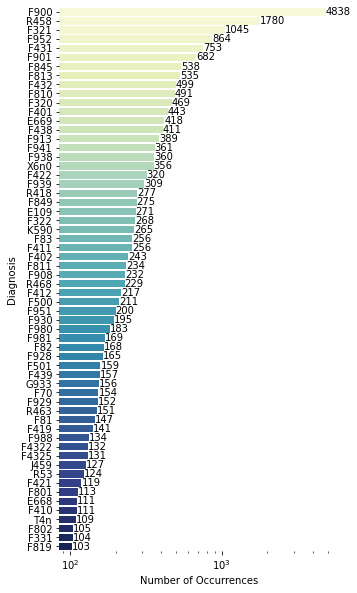

In [87]:
# -----------------------------------------
# Bar chart showing diagnosis count. If a diagnosis occur more than once in an episode it is only counted once.
#with groupby with both 'episode_id' and 'diagnosis'. any duplicate occurrences of a diagnosis within the same episode 
#will be aggregated into a single count.
# -----------------------------------------
plt.figure(figsize=(5, 10))
unique_diag_episode_df = diagnoses_df.groupby( ['episode_id', 'diagnosis']).count().reset_index()
diag_counts = unique_diag_episode_df.diagnosis.value_counts( ).loc[lambda x: x > 100]

ax = sns.barplot(x=diag_counts, y=diag_counts.index, palette="YlGnBu")

ax.bar_label(ax.containers[0]) 
ax.set_xscale("log")
ax.set_xlabel("Number of Occurrences")
ax.set_ylabel("Diagnosis")
sns.despine(left=True, bottom=True)
plt.show()

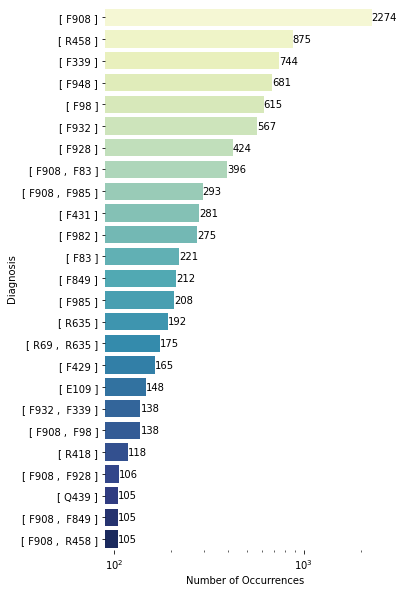

In [88]:
# -----------------------------------------
# Bar chart showing diagnosis count. If a diagnosis occur more than once in an episode it is only counted once.
# in df: 17,591 diagnoses
# -----------------------------------------
plt.figure(figsize=(5, 10))
unique_diag_episode_df = df.groupby( ['episode_id', 'diagnoses']).count().reset_index()
diag_counts = unique_diag_episode_df.diagnoses.value_counts( ).loc[lambda x: x > 100]

yvalue = convertback_to_icd_atc(diag_counts.index)
yindex2 = pd.Index([str(sublist).replace("'", " ") for sublist in yvalue ])

ax = sns.barplot(x=diag_counts, y=yindex2, palette="YlGnBu")

ax.bar_label(ax.containers[0]) 
ax.set_xscale("log")
ax.set_xlabel("Number of Occurrences")
ax.set_ylabel("Diagnosis")
sns.despine(left=True, bottom=True)
plt.show()

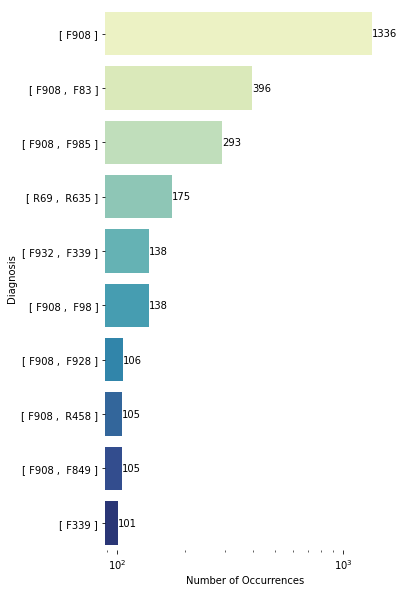

In [89]:
# -----------------------------------------
# Bar chart showing diagnosis count. If a diagnosis occur more than once in an episode it is only counted once.
#in df_exp: 9,679 - with more than one item in diag_atc
# -----------------------------------------
plt.figure(figsize=(5, 10))
unique_diag_episode_df = df_exp.groupby( ['episode_id', 'diagnoses']).count().reset_index()
diag_counts = unique_diag_episode_df.diagnoses.value_counts( ).loc[lambda x: x > 100]

yvalue = convertback_to_icd_atc(diag_counts.index)
yindex2 = pd.Index([str(sublist).replace("'", " ") for sublist in yvalue ])

ax = sns.barplot(x=diag_counts, y=yindex2, palette="YlGnBu")

ax.bar_label(ax.containers[0]) 
ax.set_xscale("log")
ax.set_xlabel("Number of Occurrences")
ax.set_ylabel("Diagnosis")
sns.despine(left=True, bottom=True)
plt.show()

# Group the DataFrame by the number of diagnoses and count the number of episodes in each group

In [90]:
len(diagnoses_df) #47,742

47742

In [91]:
# diagnoses_list_df, has 17,591 episodes with list of diagnoses
diagnoses_list_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17798 entries, 4.0 to 30938.0
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   diagnoses  17798 non-null  object
dtypes: object(1)
memory usage: 278.1+ KB


In [92]:
#del diagnoses_list_df2
data = []
diagnoses_list_df2 = pd.DataFrame(data, columns=['num_diagnoses'])

In [93]:
diagnoses_list_df2 = pd.concat([diagnoses_list_df[['diagnoses']],diagnoses_list_df2], axis=1, join='outer', ignore_index=False)

In [94]:
len(diagnoses_list_df2)

17798

In [95]:
diagnoses_list_df2['episode_id'] = diagnoses_list_df2.index

In [96]:
diagnoses_list_df2.reset_index(drop=True, inplace=True)

In [97]:
for i in range(len(diagnoses_list_df2)):
    diagnoses_list_df2.loc[i, 'num_diagnoses'] = len(diagnoses_list_df2.loc[i, 'diagnoses'])

In [98]:
diagnoses_list_df2

,diagnoses,num_diagnoses,episode_id
0,"[3131, 1019, 327]",3,4.0
1,[3001],1,6.0
2,[2781],1,7.0
3,[29622],1,8.0
4,"[304, 295, 29622]",3,9.0
...,...,...,...
17793,[2781],1,30928.0
17794,[3009],1,30929.0
17795,[313],1,30934.0
17796,[29622],1,30936.0


In [99]:
# Group the DataFrame by the number of diagnoses and count the number of episodes in each group
grouped_df = diagnoses_list_df2.groupby('num_diagnoses').size().reset_index(name='num_episodes')

In [100]:
diagnoses_list_df2.head()

diagnoses_list_df2[diagnoses_list_df2['diagnoses'].apply(len) == 0] # We did not keep the rows that diagnoses is null or []

diagnoses_list_df2[diagnoses_list_df2['diagnoses'].apply(len) == 1] # 9759 rows 

,diagnoses,num_diagnoses,episode_id
1,[3001],1,6.0
2,[2781],1,7.0
3,[29622],1,8.0
6,[1004],1,12.0
7,[313],1,14.0
...,...,...,...
17792,[2781],1,30924.0
17793,[2781],1,30928.0
17794,[3009],1,30929.0
17795,[313],1,30934.0


In [101]:
print(grouped_df)

   num_diagnoses  num_episodes
0              1          9759
1              2          5174
2              3          1925
3              4           618
4              5           200
5              6            67
6              7            33
7              8            13
8              9             5
9             10             4


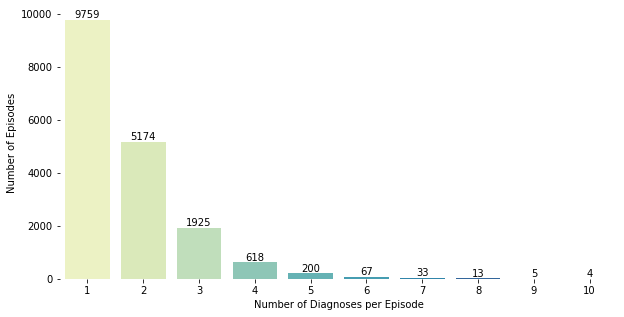

In [102]:
# show number of diagnoses per episode in initial dataset
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=grouped_df['num_diagnoses'] , y=grouped_df['num_episodes'] , palette="YlGnBu")
ax.bar_label(ax.containers[0])
ax.set_xlabel('Number of Diagnoses per Episode')
ax.set_ylabel('Number of Episodes')
sns.despine(left=True, bottom=True)
#plt.savefig('/home/kabank/workbench/.conda/analysis/ias_Diagrams/nrdiagnosesperepisode_initial.pdf')
plt.show()

In [103]:
df_exp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9739 entries, 0 to 17797
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   episode_id  9739 non-null   float64
 1   diagnoses   9739 non-null   object 
 2   atc_codes   9739 non-null   object 
 3   diag_atc    9739 non-null   object 
dtypes: float64(1), object(3)
memory usage: 380.4+ KB


In [104]:
for index, row in df_exp.iterrows():
    diagnoses_list = eval(row['diagnoses'])
    count = len(diagnoses_list)
    df_exp.loc[index, 'num_diagnoses'] = count


<ipython-input-104-cadff373aa2a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exp.loc[index, 'num_diagnoses'] = count


In [105]:
df_exp.head()

,episode_id,diagnoses,atc_codes,diag_atc,num_diagnoses
0,4.0,"['3131', '1019', '327']",[],"[3131, 1019, 327]",3.0
4,9.0,"['304', '295', '29622']",['999140601'],"[304, 295, 29622, 999140601]",3.0
5,10.0,"['3131', '3009', '313']",[],"[3131, 3009, 313]",3.0
8,15.0,"['3034', '339', '7981']",[],"[3034, 339, 7981]",3.0
11,21.0,"['3131', '304']",[],"[3131, 304]",2.0


In [106]:
# Group the DataFrame by the number of diagnoses and count the number of episodes in each group
grouped_df2 = df_exp.groupby('num_diagnoses').size().reset_index(name='num_episodes').astype(int)

In [107]:
df_exp.head()

,episode_id,diagnoses,atc_codes,diag_atc,num_diagnoses
0,4.0,"['3131', '1019', '327']",[],"[3131, 1019, 327]",3.0
4,9.0,"['304', '295', '29622']",['999140601'],"[304, 295, 29622, 999140601]",3.0
5,10.0,"['3131', '3009', '313']",[],"[3131, 3009, 313]",3.0
8,15.0,"['3034', '339', '7981']",[],"[3034, 339, 7981]",3.0
11,21.0,"['3131', '304']",[],"[3131, 304]",2.0


In [108]:
grouped_df2.head()

,num_diagnoses,num_episodes
0,1,1700
1,2,5174
2,3,1925
3,4,618
4,5,200


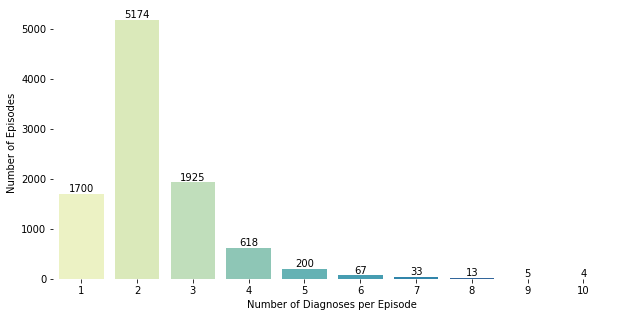

In [109]:
# show number of diagnoses per episode in experimental dataset
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=grouped_df2['num_diagnoses'] , y=grouped_df2['num_episodes'], palette="YlGnBu")
ax.bar_label(ax.containers[0])
ax.set_xlabel('Number of Diagnoses per Episode')
ax.set_ylabel('Number of Episodes')
sns.despine(left=True, bottom=True)
#plt.savefig('/home/kabank/workbench/.conda/analysis/ias_Diagrams/nrdiagnosesperepisode_experimental.pdf')
plt.show()

# Medications count

In [110]:
print(atc_df)

       episode_id   atc_code atc_code_4 atc_code_5 atc_code_3 atc_code_1
0             9.0  999140601       N06A      N06AB        N06          N
1             9.0  999140601       N06A      N06AB        N06          N
2             9.0  999140601       N06A      N06AB        N06          N
3             9.0  999140601       N06A      N06AB        N06          N
4            27.0  999140503       N05C      N05CH        N05          N
...           ...        ...        ...        ...        ...        ...
44680     30938.0  999140602       N06B      N06BA        N06          N
44681     30938.0  999140602       N06B      N06BA        N06          N
44682     30938.0  999140602       N06B      N06BA        N06          N
44683     30938.0  999140602       N06B      N06BA        N06          N
44684     30938.0  999140602       N06B      N06BA        N06          N

[44666 rows x 6 columns]


In [111]:
prescriptions_df.head()

,episode_id,regulation,prescription_type,trade_name,atc_code,atc_name
0,9.0,Fast,Blå,Zoloft,N06AB06,Sertralin
1,9.0,Fast,Blå,Zoloft,N06AB06,Sertralin
2,9.0,Fast,Blå,Zoloft,N06AB06,Sertralin
3,9.0,Fast,Blå,Fontex,N06AB03,Fluoksetin
4,27.0,Fast,Hvit,CIRCADIN,N05CH01,Melatonin


In [112]:
prescriptions_df.shape

(44666, 6)

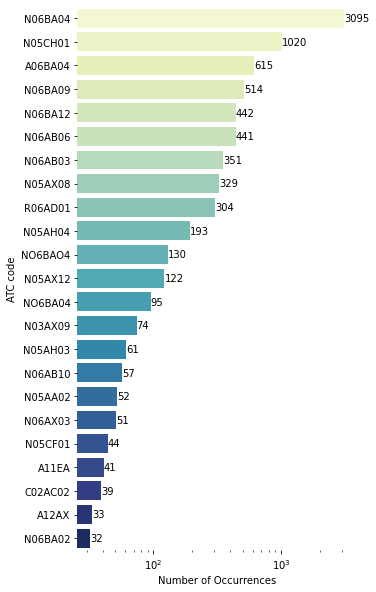

In [113]:
#-----------------------------------------
# Bar chart showing ATC count. If an ATC code occur more than once in an episode it is only counted once.
# -----------------------------------------
plt.figure(figsize=(5, 10))
unique_atc_episode_df = prescriptions_df.groupby(['episode_id', 'atc_code']).count().reset_index()
atc_counts = unique_atc_episode_df.atc_code.value_counts( ).loc[lambda x: x > 20]
ax = sns.barplot(x=atc_counts , y=atc_counts.index , palette="YlGnBu")
ax.bar_label(ax.containers[0])
ax.set_xscale("log")
ax.set_xlabel("Number of Occurrences")
ax.set_ylabel("ATC code")
sns.despine(left=True, bottom=True)
#plt.savefig('/home/kabank/workbench/.conda/analysis/ias_Diagrams/atc_count_notCut_BARPLOT.pdf' ) #, bbox_inches="tight ")
plt.show()

In [114]:
df_exp.head()


,episode_id,diagnoses,atc_codes,diag_atc,num_diagnoses
0,4.0,"['3131', '1019', '327']",[],"[3131, 1019, 327]",3.0
4,9.0,"['304', '295', '29622']",['999140601'],"[304, 295, 29622, 999140601]",3.0
5,10.0,"['3131', '3009', '313']",[],"[3131, 3009, 313]",3.0
8,15.0,"['3034', '339', '7981']",[],"[3034, 339, 7981]",3.0
11,21.0,"['3131', '304']",[],"[3131, 304]",2.0


In [115]:
df_exp.shape

(9739, 5)

In [116]:
df_exp.shape
# Explode the 'atc_codes' column to separate rows
df_exp_exploded = df_exp.explode('atc_codes')
df_exp_exploded.head()


,episode_id,diagnoses,atc_codes,diag_atc,num_diagnoses
0,4.0,"['3131', '1019', '327']",NaN,"[3131, 1019, 327]",3.0
4,9.0,"['304', '295', '29622']",['999140601'],"[304, 295, 29622, 999140601]",3.0
5,10.0,"['3131', '3009', '313']",NaN,"[3131, 3009, 313]",3.0
8,15.0,"['3034', '339', '7981']",NaN,"[3034, 339, 7981]",3.0
11,21.0,"['3131', '304']",NaN,"[3131, 304]",2.0


In [117]:
# Explode the 'atc_codes' column to separate rows
df_exploded = df.explode('atc_codes')
df_exploded.head()

,episode_id,diagnoses,atc_codes,diag_atc
0,4.0,"['3131', '1019', '327']",NaN,"[3131, 1019, 327]"
1,6.0,['3001'],NaN,[3001]
2,7.0,['2781'],NaN,[2781]
3,8.0,['29622'],NaN,[29622]
4,9.0,"['304', '295', '29622']",['999140601'],"[304, 295, 29622, 999140601]"


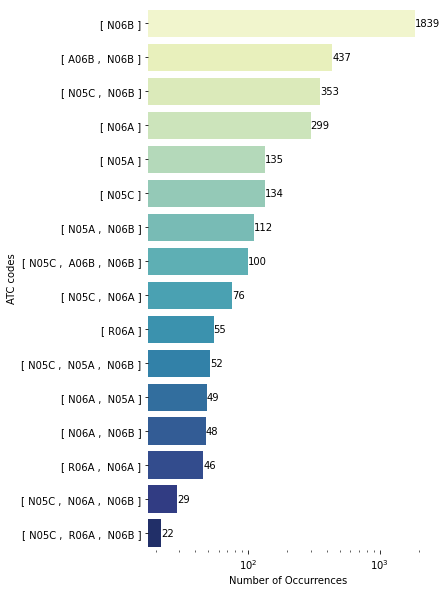

In [118]:
#-----------------------------------------
# Bar chart showing ATC count. If an ATC code occur more than once in an episode it is only counted once.
# -----------------------------------------
# Group by 'episode_id' and 'atc_codes', and then count the occurrences
unique_atc_episode_df_exp = df_exploded.groupby(['episode_id', 'atc_codes']).size().reset_index(name='count')

# Filter out atc_codes that occur more than 20 times
atc_counts = unique_atc_episode_df_exp['atc_codes'].value_counts().loc[lambda x: x > 20]

yvalue = convertback_to_icd_atc(atc_counts.index)
yindex2 = pd.Index([str(sublist).replace("'", " ") for sublist in yvalue ])

# Plot the bar chart
plt.figure(figsize=(5, 10))
ax = sns.barplot(x=atc_counts , y=yindex2 , palette="YlGnBu")
ax.bar_label(ax.containers[0])
ax.set_xscale("log")
ax.set_xlabel("Number of Occurrences")
ax.set_ylabel("ATC codes")
sns.despine(left=True, bottom=True)
#plt.savefig('/home/kabank/workbench/.conda/analysis/ias_Diagrams/atc_count_notCut_BARPLOT.pdf' ) #, bbox_inches="tight ")
plt.show()

# Group the DataFrame by the number of drugs and count the number of episodes in each group

In [119]:
prescriptions_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44666 entries, 0 to 44684
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   episode_id         44666 non-null  float64
 1   regulation         44666 non-null  object 
 2   prescription_type  39680 non-null  object 
 3   trade_name         44666 non-null  object 
 4   atc_code           44666 non-null  object 
 5   atc_name           31242 non-null  object 
dtypes: float64(1), object(5)
memory usage: 3.4+ MB


In [120]:
atc_list_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4459 entries, 9.0 to 30938.0
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   atc_code  4459 non-null   object
dtypes: object(1)
memory usage: 69.7+ KB


In [121]:
atc_list_df.head()

,atc_code
episode_id,
9.0,[999140601]
27.0,"[999140503, 999180601, 999140601, 999140602]"
28.0,[999140601]
34.0,"[999140503, 999080102, 999040601, 999140602]"
38.0,"[999140502, 999140601]"


In [122]:
atc_list_df2 = atc_list_df.copy()

In [123]:
# Calculate the number of atc_code per episode and create a new column
atc_list_df2['num_atc_codes'] = atc_list_df2['atc_code'].apply(lambda x: len(x))

# Group the DataFrame by the number of diagnoses and count the number of episodes in each group
grouped_df3 = atc_list_df2.groupby('num_atc_codes').size().reset_index(name='num_episodes')

In [124]:
grouped_df3.head()

,num_atc_codes,num_episodes
0,1,2607
1,2,1285
2,3,393
3,4,120
4,5,37


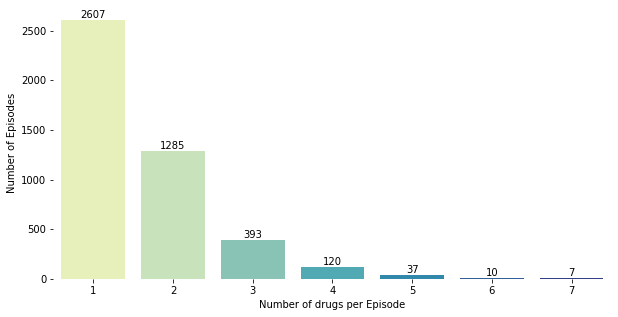

In [125]:
# show number of atc_codes per episode in initial dataset
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=grouped_df3['num_atc_codes'] , y=grouped_df3['num_episodes'] , palette="YlGnBu")
ax.bar_label(ax.containers[0])
ax.set_xlabel('Number of drugs per Episode')
ax.set_ylabel('Number of Episodes')
sns.despine(left=True, bottom=True)
#plt.savefig('/home/kabank/workbench/.conda/analysis/ias_Diagrams/nratccodes_perepisode_initial.pdf')
plt.show()

In [126]:
import ast

def safe_literal_eval(x):
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return []

# 'atc_codes' is containing the string representation of the list, to turn it back to the list:
df_exp['atc_codes'] = df_exp['atc_codes'].apply(safe_literal_eval)

<ipython-input-126-3a266d4705a7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exp['atc_codes'] = df_exp['atc_codes'].apply(safe_literal_eval)


In [127]:
# Calculate the number of atc_code per episode and create a new column
df_exp['num_atc_codes'] = df_exp['atc_codes'].apply(lambda x: len(x))

# Group the DataFrame by the number of diagnoses and count the number of episodes in each group
grouped_df4 = df_exp.groupby('num_atc_codes').size().reset_index(name='num_episodes')

<ipython-input-127-c1ca86f2481a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exp['num_atc_codes'] = df_exp['atc_codes'].apply(lambda x: len(x))


In [128]:
df_exp.head()

,episode_id,diagnoses,atc_codes,diag_atc,num_diagnoses,num_atc_codes
0,4.0,"['3131', '1019', '327']",[],"[3131, 1019, 327]",3.0,0
4,9.0,"['304', '295', '29622']",[999140601],"[304, 295, 29622, 999140601]",3.0,1
5,10.0,"['3131', '3009', '313']",[],"[3131, 3009, 313]",3.0,0
8,15.0,"['3034', '339', '7981']",[],"[3034, 339, 7981]",3.0,0
11,21.0,"['3131', '304']",[],"[3131, 304]",2.0,0


In [129]:
grouped_df4

,num_atc_codes,num_episodes
0,0,5379
1,1,2521
2,2,1273
3,3,393
4,4,119
5,5,37
6,6,10
7,7,7


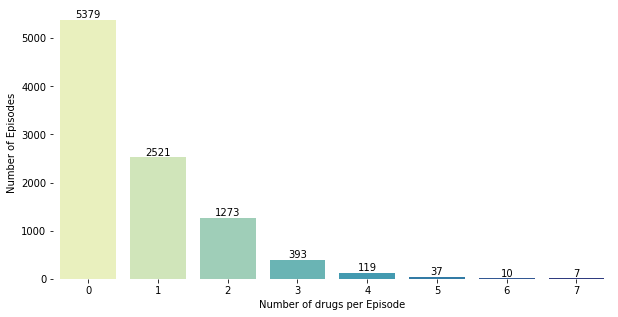

In [130]:
# show number of atc_codes per episode in experimental dataset
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=grouped_df4['num_atc_codes'] , y=grouped_df4['num_episodes'] , palette="YlGnBu")
ax.bar_label(ax.containers[0])
ax.set_xlabel('Number of drugs per Episode')
ax.set_ylabel('Number of Episodes')
sns.despine(left=True, bottom=True)
#plt.savefig('/home/kabank/workbench/.conda/analysis/ias_Diagrams/nratccodes_perepisode_experimental.pdf')
plt.show()